# Set up

### Imports

To run this code you need a google account, and to follow the link below and create a shortcut to the folder.

https://drive.google.com/drive/folders/1YHmpr-a8FPFA3dOKW2fj4No_QOiY9AjM

The code snippet below allow for accessing this folder

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Write the path to the folder shortcut with the feature files

In [2]:
%cd gdrive/MyDrive/Experiments-feature-files

/content/gdrive/.shortcut-targets-by-id/1YHmpr-a8FPFA3dOKW2fj4No_QOiY9AjM/Experiments-feature-files


Test that everything worked correct by running the cell below and make sure you see these three files: 

Anomaly_Detection_train_test_features \\
Gas_Leak_E4_train_test_features \\
Gas_Leak_E1-E2-E3_train_test_features \\

In [3]:
!ls

Anomaly_Detection_train_test_features  Gas_Leak_E4_train_test_features
Gas_Leak_E1-E2-E3_train_test_features


Run cell to import whats needed

In [4]:
import librosa
import matplotlib.pyplot as plt    
import numpy as np
import pandas as pd 
import seaborn as sns

from scipy import signal
from scipy.stats import norm, kurtosis
from scipy.signal import welch
from scipy.integrate import simps


import operator
import glob 
import json
from datetime import datetime

##import warnings
##warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
import statistics

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

Loading data with features for experiment

In [5]:
df_train_features = pd.read_csv("Anomaly_Detection_train_test_features")

In [ ]:
df_train_features

# Functions

## Helper functions 

In [7]:
#Method used to standerize features
def preprocesses(X,T,normalize=True):
  if normalize:
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X))
    X_scaled.columns = X.columns
    T_scaled = pd.DataFrame(scaler.transform(T))
    T_scaled.columns = T.columns

  return X_scaled, T_scaled 


In [8]:
#Method used to separate data from target labels for both train and test data
def get_data_labels(df_train_features, df_test_features, drop_features=None):

  df_train_features_drop = df_train_features.drop(columns=['feature_index', 'index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')
  df_test_features_drop = df_test_features.drop(columns=['feature_index','index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')


  y = df_train_features_drop['leak_present'].values
  X = df_train_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    X = X.drop(columns=drop_features)

  gt = df_test_features_drop['leak_present'].values
  T = df_test_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    T = T.drop(columns=drop_features)



  return X,y,T,gt


# Run code

#### Storing all the potentials models in a dictionary

In [9]:
models = {
  #"oc-svm_nu=0.01": OneClassSVM(gamma='scale',nu=0.01),
  "oc-svm_nu=0.1": OneClassSVM(gamma='scale',nu=0.1),
  #"oc-svm_nu=0.2": OneClassSVM(gamma='scale',nu=0.2),
  #"oc-svm_nu=0.5": OneClassSVM(gamma='scale',nu=0.5),
  #"oc-svm_auto": OneClassSVM(gamma='scale'),


  "lof_auto" : LocalOutlierFactor(novelty=True, contamination="auto"),
  #"lof_con=0.1" : LocalOutlierFactor(novelty=True, contamination=0.1),
  #"lof_0.01" : LocalOutlierFactor(novelty=True, contamination=0.01),
  #"lof_0.2" : LocalOutlierFactor(novelty=True, contamination=0.2),

  #"if10": IsolationForest(n_estimators=10, warm_start=False),
  #"if20": IsolationForest(n_estimators=20, warm_start=False),
  #"if50": IsolationForest(n_estimators=50, warm_start=False),
  #"if_boot": IsolationForest(warm_start=False,bootstrap=True),
  "if_default": IsolationForest(warm_start=False),
  #"if_con=0.1": IsolationForest(n_estimators=100, warm_start=False, contamination=0.1),
}

Training and predicting 

In [10]:
def anomaly_detection(X, envs):
  all_results_OCCs = {}

  #Iterating over all the combinations
  for env in envs: 
    X = df_train_features

    print("Train: ", env[0])
    print("Test: ", env[1])
    
    #Selecting the environemnt to be tested in this iteration 
    X = X[X['environment'].isin(env)] 
    y = X.leak_present.values

    #Prepering for cross-validation with 3 splits 
    cv = StratifiedGroupKFold(n_splits=3)
    env_groups = X.recording.values

    #Potential subsets of features 
    features_all = []
    features_top_1 = ["spec_bandwidth","rp_bin: 5"]
    features_top_2 = ["mfcc_bin: 5","rp_bin: 5"]
    features_top_3 = ["mfcc_bin: 5","rp_bin: 5","mfcc_bin: 4", "rp_bin: 4", "spec_bandwidth", "spec_centroid", "cont_bin: 6"]
    sub_features = features_top_3

    all_results = {}
    #Iterating over all the 
    for model in models: 
      results = {}
      for train_idxs, test_idxs in cv.split(X,y,env_groups):
        #Seperating train and test data
        X_train_features = X.iloc[train_idxs].loc[(X.iloc[train_idxs].leak_present == 0)] #Train data is only negative labels  
        X_test_features = X.iloc[test_idxs] #Test features is all 

        #If we want to split train and test further:
        X_train_features = X_train_features[X_train_features['environment'] == env[0]]
        X_test_features = X_test_features[X_test_features['environment'] == env[1]]

        #Used for plotting later
        X_train_features_lp = X_train_features["leak_present"]
        X_test_features_lp = X_test_features["leak_present"]
        
        #Getting only relevant features and splitting data and labels
        X_train, y_train, X_test, y_test = get_data_labels(X_train_features, X_test_features)
        #Normalizing the data 
        X_train, X_test = preprocesses(X_train, X_test)

        #Only using selected features
        if sub_features: 
          X_train = X_train[sub_features]
          X_test = X_test[sub_features]

        #Also used for plotting later 
        X_train_features_lp.reset_index(drop=True, inplace=True)
        X_train_info = pd.concat([X_train, X_train_features_lp], axis=1)
        
        #LOF needs different input from the rest 
        if "lof" in model:
          models[model].fit(X_train.values) 
        else:
          models[model].fit(X_train)
        #try: 
        #  models[model].fit(X_train)
        #except: 
        #  models[model].fit(X_train.values) 


        #Converting the predictions to the same format as in training data 
        preds = models[model].predict(X_test)
        preds = [1 if i==-1 else 0 for i in preds]

        #Storing predictions as column and concating with test data 
        pred_col = pd.DataFrame(preds)
        pred_col.columns = ["preds"]
        pred_col.reset_index(drop=True, inplace=True)
        X_test_features.reset_index(drop=True, inplace=True)
        X_test_info_preds = pd.concat([X_test_features, pred_col["preds"]], axis=1)
        x_test_preds = X_test_info_preds

        #Also used for plotting 
        X_test_features_lp.reset_index(drop=True, inplace=True)
        X_test_info = pd.concat([X_test, X_test_features_lp], axis=1)
        

        #Seperating predictions based on leak-type
        for leak in x_test_preds.leak_type.unique():
            preds = x_test_preds.loc[(x_test_preds.leak_type == leak)]["preds"]
            y_test = x_test_preds.loc[(x_test_preds.leak_type == leak)]["leak_present"]
            f1 = f1_score(preds, y_test)
            acc = accuracy_score(preds, y_test)
            key = str(leak)
            metric = f1
            if key in results:
              results[key].append(metric)
            else:
              results[key] = [metric]

      #Averaging score over the three cv-folds     
      average_results = {}
      for key, vals in results.items():
        if 0 in vals: #Marking predictions with errors with "*"
          vals.remove(0)
          average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
        else: 
          average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

        #Storing average result for current model in a dictionary
        all_results[model] = average_results

    all_results_OCCs[env[0]+"->"+env[1]] = all_results

  
  return all_results_OCCs

In [11]:
#Data 
X = df_train_features

#Combinations of train and test environments
envs = [["lab", "lab"],["hydr", "hydr"],["work", "work"],["hydr", "hydr_low"],["work", "work_low"]]

anomaly_detection_score = anomaly_detection(X, envs)

for key,val in anomaly_detection_score.items():
  print(key)
  print("_____")
  for model in val: 
    print(model)
    sum = []
    for res, resval in val[model].items(): 
      sum.append(resval[0])
      print(str(resval[0])[0:5],str(resval[1])[0:4] )
    print(str(np.mean(sum))[:5]+ "," + str(statistics.pstdev(sum))[:4])

Train:  lab
Test:  lab
Train:  hydr
Test:  hydr
Train:  work
Test:  work
Train:  hydr
Test:  hydr_low
Train:  work
Test:  work_low
lab->lab
_____
oc-svm_nu=0.1
85.14 12.3
88.02 6.77
82.90 12.4
85.35,2.09
lof_auto
89.01 12.0
86.00 10.0
86.97 9.73
87.33,1.25
if_default
88.76 6.97
88.12 5.32
86.76 5.99
87.88,0.83
hydr->hydr
_____
oc-svm_nu=0.1
81.34 3.13
81.83 0.99
31.42 5.29
64.87,23.6
lof_auto
88.64 0.19
88.58 2.55
43.37 2.37
73.53,21.3
if_default
80.84 0.65
79.62 0.64
53.91 7.41
71.45,12.4
work->work
_____
oc-svm_nu=0.1
82.43 7.30
83.58 5.17
69.93 8.81
78.65,6.18
lof_auto
89.30 5.08
87.26 4.89
65.31 13.5
80.63,10.8
if_default
81.37 5.89
81.86 3.92
59.85 21.1
74.36,10.2
hydr->hydr_low
_____
oc-svm_nu=0.1
82.87 1.23
74.45 4.37
41.32 2.26
66.21,17.9
lof_auto
76.74 0.72
71.06 1.90
42.60 4.05
63.47,14.9
if_default
71.40 1.97
66.18 0.38
46.28 1.61
61.29,10.8
work->work_low
_____
oc-svm_nu=0.1
77.94 6.38
82.23 11.2
82.07 4.55
80.75,1.98
lof_auto
83.74 7.89
83.45 11.8
83.52 7.54
83.57,0.12
if_

#### Plotting boundaries for all models 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  "X does not have valid feature names, but"


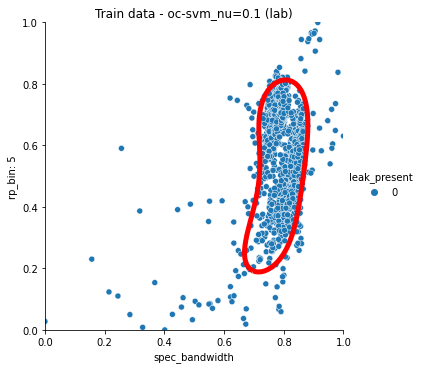

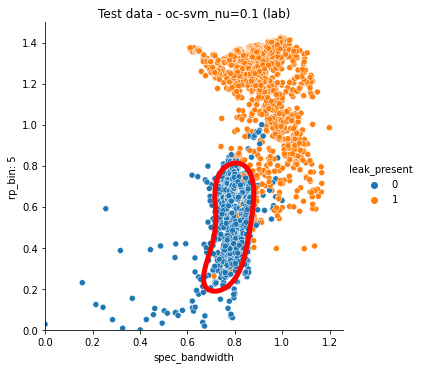

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


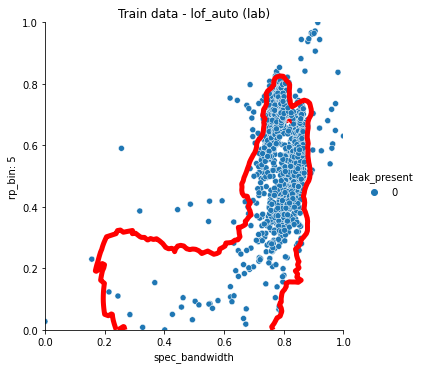

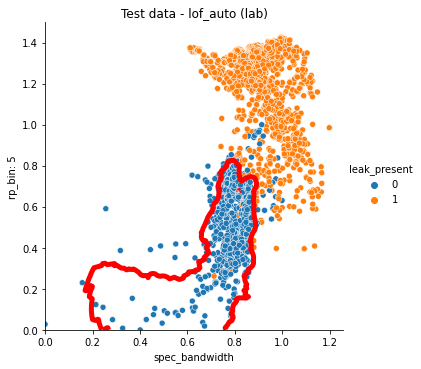

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


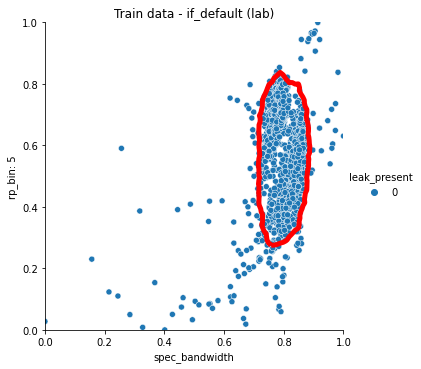

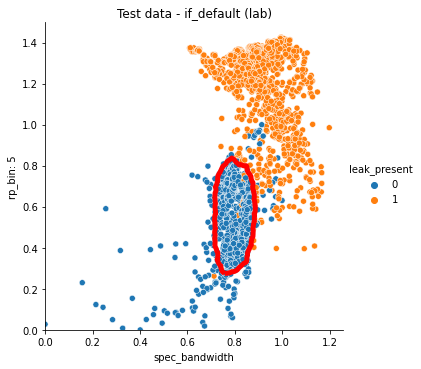

In [ ]:
#Plotting decision boundary for labs
exploring_env = ["lab", "lab"]
plot_X_train = df_train_features.loc[(df_train_features.leak_present == 0) & (df_train_features['environment'] == exploring_env[0])]
plot_X_test = df_train_features[df_train_features['environment']== exploring_env[0]]

plot_X_train_lp = plot_X_train["leak_present"]
plot_X_test_lp = plot_X_test["leak_present"]

#Using two features for plotting in 2d 
features = ["spec_bandwidth", "rp_bin: 5"]

plot_X_train,plot_X_test = preprocesses(plot_X_train[features],plot_X_test[features])

plot_X_train_lp.reset_index(drop=True, inplace=True)
plot_X_train = pd.concat([plot_X_train, plot_X_train_lp], axis=1)

plot_X_test_lp.reset_index(drop=True, inplace=True)
plot_X_test = pd.concat([plot_X_test, plot_X_test_lp], axis=1)

for model in models: 
  plot_model = models[model]
  sns.relplot(data=plot_X_train, x=features[0], y=features[1], hue="leak_present", height=5,  aspect=1)    
  xx1, yy1 = np.meshgrid(np.linspace(0,1, 100), np.linspace(0,1, 100))
  plot_model.fit(plot_X_train[features])
  Z1 = plot_model.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
  Z1 = Z1.reshape(xx1.shape)
  plt.contour(xx1, yy1, Z1, levels=[0], linewidths=5, colors="red")
  plt.title("Train data - " + model + " ("+exploring_env[0]+")")
  plt.show()


  sns.relplot(data=plot_X_test, x=features[0], y=features[1], hue='leak_present', height=5,  aspect=1)
  plt.contour(xx1, yy1, Z1, levels=[0], linewidths=5, colors="red")
  plt.title("Test data - " + model + " ("+exploring_env[0]+")")
  plt.show()